### Inspired by: https://www.youtube.com/watch?v=aU8OF0htbTo&t=133s&ab_channel=PatrickLoeber

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
from torchvision import transforms
from tqdm import tqdm
from pathlib import Path

In [4]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda:0")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    device = torch.device("cpu")
print(f"Using device: {device}")

data_dir = Path(r"/mnt/c/Users/saulg/Desktop/dl_datasets/dogs_vs_cats")

GPU is available!
Using device: cuda:0


In [5]:
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((280,280)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
        ),
])

test_transform = transforms.Compose([
    transforms.Resize((280, 280)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
        ),
])

train_dataset = torchvision.datasets.ImageFolder(data_dir / "train", transform=train_transform)
#valid_dataset = torchvision.datasets.ImageFolder(data_dir / "valid", transform=test_transform)
test_dataset = torchvision.datasets.ImageFolder(data_dir / "test", transform=test_transform)

In [6]:
for image,label in train_dataset:
    print(image.shape)
    break

torch.Size([3, 280, 280])


In [7]:
# check class names
print(train_dataset.classes)

['cat', 'dog']


In [8]:
batch_size_train = 1
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
#valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size_train, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_train, shuffle=False)

In [9]:
iter_ = iter(train_loader)
image,label = next(iter_)
print(image.shape)
print(label)

torch.Size([1, 3, 280, 280])
tensor([1])


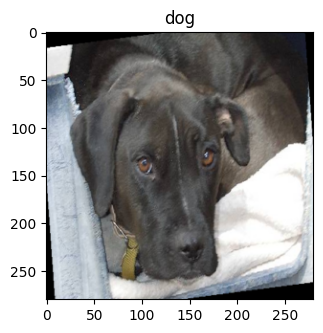

In [10]:
def image_convert(
    img, 
    std=[0.5,0.5,0.5], 
    mean=[0.5,0.5,0.5],
    ):
    img = img.clone().cpu().numpy()
    img = img.transpose(1,2,0)
    img = img*std + mean
    return img


def plot_sample_images(dataloader=train_loader, n_images=batch_size_train):
        iter_ = iter(train_loader)
        images,labels = next(iter_)
        an_ = {'0':'cat','1':'dog'}
        
        plt.figure(figsize=(20,10))
        for idx in range(n_images):
            plt.subplot(2,5,idx+1)
            img = image_convert(images[idx])
            label = labels[idx]
            plt.imshow(img)
            plt.title(an_[str(label.numpy())])
        plt.show()

plot_sample_images(n_images=1)

### Building the Network

In [11]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1).to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
from torch import nn
class classification_head(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(512,120)
        self.linear2=nn.Linear(120,2)
    
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [13]:
model_ = classification_head().to(device)
model.fc = model_

In [14]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# freeze all layers
for param in model.parameters():
        param.requires_grad = False
# unfreeze the last layer
for param in model.fc.parameters():
        param.requires_grad = True

In [ ]:
# output = model(example_data)

# # convert output probabilities to predicted class
# probabilities = F.softmax(output, dim=1)
# print(probabilities)
# _, preds_tensor = torch.max(probabilities, 1)
# print(preds_tensor)

### Define training loop

In [ ]:
# def train(model, data_loader, optimizer, loss_fn, device):
#     model.train()
#     loss_total = 0.0
#     correct = 0
#     total_samples = 0

#     for x, y in data_loader:
#         x, y = x.to(device), y.to(device)
#         optimizer.zero_grad()
#         y_hat = model(x)
#         loss = loss_fn(y_hat, y)
#         loss.backward()
#         optimizer.step()
#         loss_total += loss.item()
#         correct += (y_hat.argmax(1) == y).sum().item()
#         total_samples += y.size(0)

#     accuracy = 100.0 * correct / total_samples
#     loss_total /= len(train_loader)

#     return loss_total, accuracy

# # Validation function
# def validate(model, data_loader, loss_fn, device):
#     model.eval()
#     loss_total = 0.0
#     correct = 0
#     total_samples = 0

#     with torch.no_grad():
#         for x, y in data_loader:
#             x, y = x.to(device), y.to(device)
#             y_hat = model(x)
#             loss = loss_fn(y_hat, y)
#             loss_total += loss.item()
#             correct += (y_hat.argmax(1) == y).sum().item()
#             total_samples += y.size(0)

#     accuracy = 100.0 * correct / total_samples
#     loss_total /= len(data_loader)

#     return loss_total, accuracy

# def evaluate(model, data_loader, device):
#     model.eval()
#     predictions = []
#     correct = 0
#     total_samples = 0

#     with torch.no_grad():
#         for x, y in data_loader:
#             x, y = x.to(device), y.to(device)
#             y_hat = model(x)
#             correct += (y_hat.argmax(1) == y).sum().item()
#             total_samples += y.size(0)

#     accuracy = 100.0 * correct / total_samples
#     return torch.cat(predictions), accuracy


# def predict(model, data_loader, device):
#     model.eval()
#     predictions = []

#     with torch.no_grad():
#         for x in data_loader:
#             x = x.to(device)
#             y_hat = model(x)
#             _, predicted = y_hat.max(1)
#             predictions.append(predicted)

#     return torch.cat(predictions)

# class EarlyStopper:
#     def __init__(self, patience=1, min_delta=0):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.counter = 0
#         self.best_validation_loss = float('inf')
#         self.best_model_weights = None

#     def early_stop(self, validation_loss, model):
#         if validation_loss < self.best_validation_loss - self.min_delta:
#             self.best_validation_loss = validation_loss
#             self.counter = 0
#             self.save_best_weights(model)
#         else:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 return True
#         return False

#     def save_best_weights(self, model):
#         self.best_model_weights = deepcopy(model.state_dict())

#     def restore_best_weights(self, model):
#         model.load_state_dict(self.best_model_weights)

In [ ]:
# # Lists to store loss and accuracy
# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []

# # Training parameters
# n_epochs = 100
# learning_rate = 0.01
# momentum = 0.5
# log_interval = 10
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Instantiate model, loss function, and optimizer
# model = model.to(device)
# criteria = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
# early_stopper = EarlyStopper(patience=5, min_delta=0.001)

# for epoch in tqdm(range(n_epochs), desc='Training Progress'):
#     # Training
#     train_loss, train_acc = train(model, train_loader, optimizer, criteria, device)
#     train_losses.append(train_loss)
#     train_accuracies.append(train_acc)
#     print(f"[{epoch+1}/{n_epochs}] Train loss: {train_loss:.4f} acc: {train_acc:.2f}%")

#     # Validation
#     val_loss, val_acc = validate(model, test_loader, criteria, device)
#     val_losses.append(val_loss)
#     val_accuracies.append(val_acc)
#     print(f'[{epoch+1}/{n_epochs}] Val loss: {val_loss:.4f} acc: {val_acc:.2f}%')

#     if early_stopper.early_stop(val_loss, model):
#         early_stopper.save_best_weights(model)
# early_stopper.restore_best_weights(model)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

train_loss = []
val_loss = []

epochs = 5

for epoch in range(epochs):
      print("epoch {}/{}".format(epoch+1,epochs))
      running_loss = 0.0
      running_score = 0.0
#       model.train()
      for image,label in train_loader:
          image = image.to(device)
          label = label.to(device)
          optimizer.zero_grad()
          y_pred = model.forward(image)
          loss = criterion(y_pred,label)         
          loss.backward() #calculate derivatives 
          optimizer.step() # update parameters
          val, index_ = torch.max(y_pred,axis=1)
          running_score += torch.sum(index_ == label.data).item()
          running_loss += loss.item()
      
      epoch_score = running_score/len(train_loader.dataset)
      epoch_loss = running_loss/len(train_loader.dataset)
      train_loss.append(epoch_loss)
      print("Training loss: {}, accuracy: {}".format(epoch_loss,epoch_score))
      
      with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          for image,label in test_loader:
                image = image.to(device)
                label = label.to(device)
                optimizer.zero_grad()
                y_pred = model.forward(image)
                loss = criterion(y_pred,label)
                running_loss += loss.item()

                val, index_ = torch.max(y_pred,axis=1)
                running_score += torch.sum(index_ == label.data).item()
          
          epoch_score = running_score/len(test_loader.dataset)
          epoch_loss = running_loss/len(test_loader.dataset)
          val_loss.append(epoch_loss)
          print("Validation loss: {}, accuracy: {}".format(epoch_loss,epoch_score))

epoch 1/5


/home/saul/.pyenv/versions/3.11.5/envs/pytorch-dev/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Training loss: 0.6992719594538211, accuracy: 0.49
Validation loss: 0.6829627799987793, accuracy: 0.64
epoch 2/5
Training loss: 0.20961171941908288, accuracy: 0.913
Validation loss: 0.07141295007480948, accuracy: 0.98
epoch 3/5
Training loss: 0.09083835876917123, accuracy: 0.968
Validation loss: 0.11899025511600485, accuracy: 0.94
epoch 4/5
Training loss: 0.07634818256710582, accuracy: 0.975
Validation loss: 0.015455347793379133, accuracy: 1.0
epoch 5/5
Training loss: 0.0685398035044925, accuracy: 0.972
Validation loss: 0.013623913912315402, accuracy: 1.0


In [17]:
import numpy as np
def plot_val_images():

    label_dict = ['cat','dog']
 
    iter_ = iter(test_loader)
    images,labels = next(iter_)
    images = images.to(device)
    pred_labels = labels.to(device)

    
    img_out = model.forward(images)
    value, index_val = torch.max(img_out, 1)

    # label = label_dict[str(label)]
    fig = plt.figure(figsize=(35,9))
    for idx in np.arange(10):
        ax = fig.add_subplot(2,5,idx+1)
        plt.imshow(image_convert(images[idx]))
        label = labels[idx]  
        pred_label = pred_labels[idx]
        ax.set_title('Act {},pred {}'.format(label_dict[label],label_dict[pred_label]))

IndexError: index 1 is out of bounds for dimension 0 with size 1

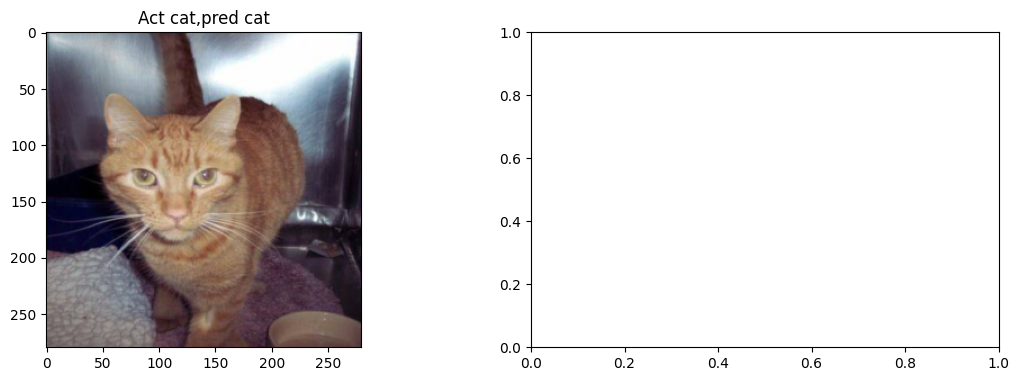

In [18]:
plot_val_images()